In [1]:
from environment import utils, Environment
from importlib import reload
import matplotlib.pyplot as plt


from absl import flags
FLAGS = flags.FLAGS

import numpy as np

if not FLAGS.find_module_defining_flag('vega_obs', default=None): 
    flags.DEFINE_boolean('vega_obs', True, 'Include portfolio vega and hedging option vega in state variables (Default False)')
# set vega obs to True to include vega in state variables
FLAGS['vega_obs'].value = True
FLAGS.mark_as_parsed()



TypeError: The decorated object is not a function (got type <class 'staticmethod'>).

t_max set to 4
n_curves is none, setting n_curves to n_samples=1
random_curves set to False, using the first n_curves of the dataframe
creating df init for n_curves=1
done creating df_init


/home/hedge/venv/lib/python3.9/site-packages/traitlets/traitlets.py:1385: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  warn(


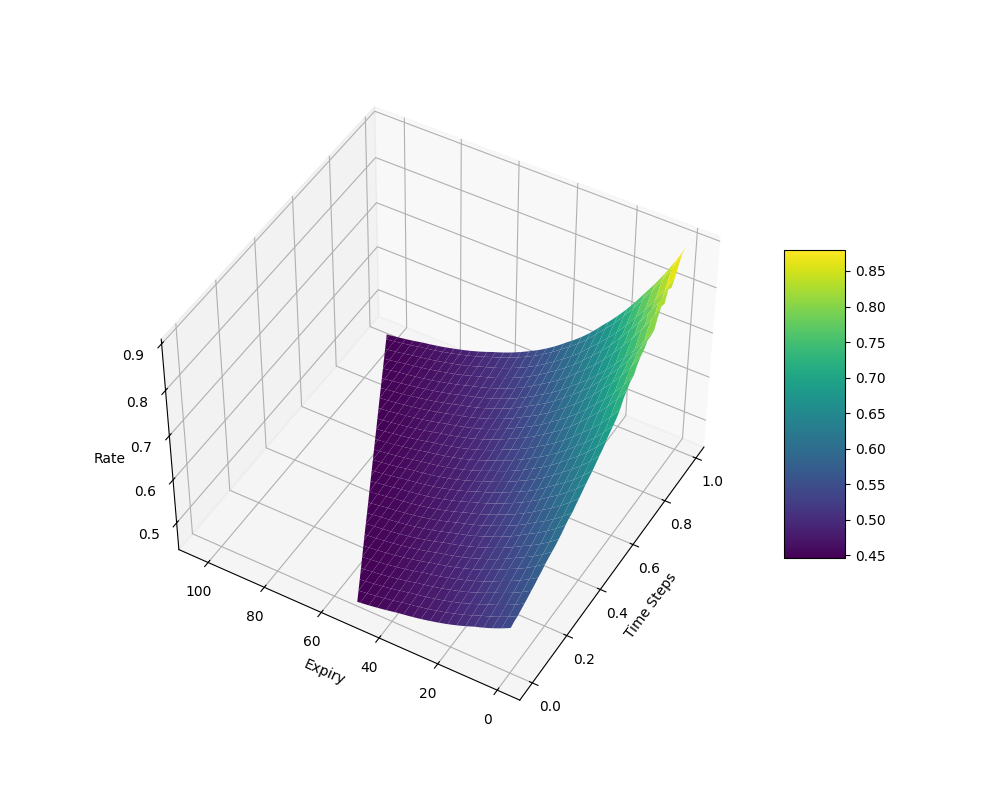

In [68]:
from importlib import reload
from environment import lmmsabr
import matplotlib.pyplot as plt
reload(lmmsabr)
lmm = lmmsabr.LMMSABR(tenor=1, resolution=26)
lmm.sample_starting_conditions(g_kwargs={'params':(0.04,0.1538,1.2447,0.0202)}, h_kwargs={'params':(1.1138, 0.0002,1.9833,0.3069)})
lmm.prime()
lmm.simulate(seed=3)
lmm.get_swap_matrix()
lmm.get_sabr_params()
lmm.samples
import numpy as np
#np.sum(lmm.k_tensor_prod,axis=(2,3))
#print(lmm.swap_idxs[0],lmm.swap_idxs[1])
#lmm.plot(lmm.ttm_mat[np.ix_(lmm.swap_idxs[0],lmm.swap_idxs[1])]*lmm.alpha)
#lmm.plot(np.sqrt(2*np.sum(lmm.V_terms,axis=(2,3)))/ (lmm.ttm_mat[np.ix_(lmm.swap_idxs[0],lmm.swap_idxs[1])]*lmm.alpha))
lmm.plot(lmm.V)
plt.show()


In [673]:
from matplotlib import pyplot as plt


In [678]:
(swaption_hedge, swap_hedge), (swaption_liab, swap_liab) = lmm.get_sabr_params()

In [704]:
lmm.get_swap_matrix()
#print(lmm.swap_indices[1][0,0])
#print(lmm.swap_indices[1][0,:])
lmm.swap_indexer(lmm.s_mat_interp)[0,0]*lmm.W[0,0]
(lmm.swap_indexer(lmm.s_mat_interp)[0,:]*lmm.W[0,:]).shape

(104, 2)

In [750]:
import numpy as np

# 1) Get your 2-leg indices
idx       = lmm.swap_indices[1]      # shape (52,104,2)
idx_main  = idx[0, 0, :]             # shape (2,), e.g. [52,78]
idx_port  = idx[0, :, :]             # shape (104,2)

# 2) Expand to (104,2,2) so each [j,i,k] pairs main-leg i with port-leg k
idx_main_exp = np.broadcast_to(idx_main[None, :, None], (104, 2, 2))
idx_port_exp = np.broadcast_to(idx_port[:, None, :],    (104, 2, 2))

# 3) Grab the 4×104 correlations
corr = lmm.rho_mat                  # shape (N,N)
corr_block = corr[idx_main_exp, idx_port_exp]  # (104,2,2)

# 4) Volatilities: take row-0 of your simulated matrix, then expand
sigma0         = lmm.s_mat_interp[0]            # shape (N,)
sigma_main_exp = np.broadcast_to(sigma0[idx_main][None,:,None], (104,2,2))
sigma_port_exp = np.broadcast_to(sigma0[idx_port][:,:,None],      (104,2,2))

# 5) Weights: pull main and port legs, then expand
w_main         = lmm.W[0, 0, :]                 # shape (2,)
w_port         = lmm.W[0, :, :]                 # shape (104,2)
w_main_exp     = np.broadcast_to(w_main[None,:,None], (104,2,2))
w_port_exp     = np.broadcast_to(w_port[:,:,None],    (104,2,2))

# 6) Element-wise multiply all four terms and sum over legs
cov_contrib = corr_block \
            * sigma_main_exp * sigma_port_exp \
            * w_main_exp     * w_port_exp       # shape (104,2,2)

# collapse the two inner axes → one covariance per portfolio swap
covs = cov_contrib.sum(axis=(1,2))               # shape (104,)

# covs[j] is Cov( swap(0,0), swap(0,j) ), including all four cross-terms
regs = covs/(covs[0])
#plt.plot(lmm.s_mat_interp[0,52:]/lmm.s_mat_interp[0,52])
#plt.show()
regs

array([1.          , 0.9996159194, 0.9992345323, 0.9988558585, 0.9984799173, 0.9981067275, 0.9977363079, 0.9973686765, 0.9970038511, 0.996641849 , 0.996282687 , 0.9959263814, 0.9955729481, 0.9952224025, 0.9948747593, 0.9945300329, 0.994188237 , 0.9938493847, 0.9935134887, 0.9931805609, 0.9928506128, 0.9925236551, 0.992199698 , 0.9918787511, 0.9915608232, 0.9912459225, 0.9909340568, 0.9882398649, 0.9855584226, 0.9828896632, 0.9802335204, 0.9775899286, 0.9749588229, 0.9723401385, 0.9697338116, 0.9671397785, 0.9645579763, 0.9619883421, 0.9594308139, 0.95688533  , 0.9543518288, 0.9518302496, 0.9493205316, 0.9468226147, 0.9443364389, 0.9418619448, 0.9393990731, 0.9369477648, 0.9345079613, 0.9320796043, 0.9296626357, 0.9272569976, 0.9248626325,          nan,          nan,          nan,          nan,          nan,          nan,          nan,          nan,          nan,          nan,          nan,          nan,          nan,          nan,          nan,          nan,          nan,          nan,

In [753]:
import numpy as np

# 1) Get your 2-leg indices
step = 1
idx       = lmm.swap_indices[1]      # shape (52,104,2)
idx_main  = idx[0, step, :]             # shape (2,), e.g. [52,78]
idx_port  = idx[0, :, :]             # shape (104,2)

# 2) Expand to (104,2,2) so each [j,i,k] pairs main-leg i with port-leg k
idx_main_exp = np.broadcast_to(idx_main[None, :, None], (104, 2, 2))
idx_port_exp = np.broadcast_to(idx_port[:, None, :],    (104, 2, 2))

# 3) Grab the 4×104 correlations
corr = lmm.rho_mat                  # shape (N,N)
corr_block = corr[idx_main_exp, idx_port_exp]  # (104,2,2)

# 4) Volatilities: take row-0 of your simulated matrix, then expand
sigma0         = lmm.s_mat_interp[step]            # shape (N,)
sigma_main_exp = np.broadcast_to(sigma0[idx_main][None,:,None], (104,2,2))
sigma_port_exp = np.broadcast_to(sigma0[idx_port][:,:,None],      (104,2,2))

# 5) Weights: pull main and port legs, then expand
w_main         = lmm.W[step, step, :]                 # shape (2,)
w_port         = lmm.W[step, :, :]                 # shape (104,2)
w_main_exp     = np.broadcast_to(w_main[None,:,None], (104,2,2))
w_port_exp     = np.broadcast_to(w_port[:,:,None],    (104,2,2))

# 6) Element-wise multiply all four terms and sum over legs
cov_contrib = corr_block \
            * sigma_main_exp * sigma_port_exp \
            * w_main_exp     * w_port_exp       # shape (104,2,2)

# collapse the two inner axes → one covariance per portfolio swap
covs = cov_contrib.sum(axis=(1,2))               # shape (104,)

# covs[j] is Cov( swap(0,0), swap(0,j) ), including all four cross-terms
regs = covs/(covs[step])
#plt.plot(lmm.s_mat_interp[0,52:]/lmm.s_mat_interp[0,52])
#plt.show()
regs

array([0.9984429444, 1.          , 0.9995122792, 0.9990278956, 0.9985468648, 0.9980692018, 0.9975949213, 0.9971240378, 0.9966565651, 0.9961925169, 0.9957319063, 0.9952747461, 0.9948210486, 0.9943708254, 0.993924088 , 0.9934808472, 0.9930411133, 0.992604896 , 0.9921722048, 0.9917430482, 0.9913174345, 0.9908953712, 0.9904768653, 0.9900619234, 0.9896505511, 0.9892427538, 0.9888385359, 0.9872022025, 0.9845401912, 0.98189073  , 0.9792537535, 0.976629197 , 0.9740169962, 0.9714170874, 0.9688294074, 0.9662538933, 0.963690483 , 0.9611391145, 0.9585997264, 0.9560722577, 0.9535566477, 0.9510528363, 0.9485607635, 0.9460803698, 0.943611596 , 0.9411543833, 0.9387086731, 0.9362744071, 0.9338515273, 0.9314399762, 0.9290396961, 0.9266506299, 0.9242727206, 0.9211307525,          nan,          nan,          nan,          nan,          nan,          nan,          nan,          nan,          nan,          nan,          nan,          nan,          nan,          nan,          nan,          nan,          nan,

In [774]:
import pickle

file_path = '/home/hedge/gamma-vega-rl-hedging/data/swaption_memmap/20250418-135858/lmm_samples.pkl'

try:
    with open(file_path, 'rb') as f:
        data = pickle.load(f)
    print(f"Successfully loaded data from {file_path}")
    # You can now work with the 'data' variable
    # For example, print its type or content (be careful with large files)
    # print(type(data))
    # print(data)
except FileNotFoundError:
    print(f"Error: File not found at {file_path}")
except Exception as e:
    print(f"An error occurred while loading the pickle file: {e}")


An error occurred while loading the pickle file: Ran out of input


In [775]:
import numpy as np

# 0) unpack
idx        = lmm.swap_indices[1]    # shape (S,J,2)
rho        = lmm.rho_mat            # shape (N,N)
sigma_all  = lmm.s_mat_interp       # shape (S,N)
f_all      = lmm.f_sim              # shape (S,N)
beta       = lmm.beta               # scalar
W_all      = lmm.W                  # shape (S,J,2)

# dimensions
S, J = idx.shape[0], idx.shape[1]
steps = np.arange(S)

# 1) main/port indices
#    main_idx[s] = the two forwards for swap(s,s)
main_idx = idx[steps, steps, :]     # shape (S,2)
#    port_idx[s,j] = the two forwards for swap(s,j)
port_idx = idx                      # shape (S,J,2)

# 2) build 4-corners index blocks of shape (S,J,2,2)
main_exp = np.broadcast_to(
    main_idx[:, None, :, None],     # (S,1,2,1)
    (S, J, 2, 2)
)
port_exp = np.broadcast_to(
    port_idx[:, :, None, :],        # (S,J,1,2)
    (S, J, 2, 2)
)

# 3) gather all 4 correlations per (s,j)
rho_block = rho[main_exp, port_exp]  # → shape (S,J,2,2)

# 4) full forward vols = σ * (f^β)
vol_all = sigma_all * (f_all[:,:-26] ** beta)  # (S, N)

# 5) pull out & broadcast vols into (S,J,2,2)
vol_main_vec = vol_all[steps[:,None], main_idx]      # (S,2)
vol_port_vec = vol_all[steps[:,None,None], port_idx] # (S,J,2)

vol_main = np.broadcast_to(
    vol_main_vec[:, None, :, None],  # (S,1,2,1)
    (S, J, 2, 2)
)
vol_port = np.broadcast_to(
    vol_port_vec[:, :, :, None],     # (S,J,2,1)
    (S, J, 2, 2)
)

# 6) pull out & broadcast weights into (S,J,2,2)
w_main_vec = W_all[steps, steps, :]                # (S,2)
w_port_vec = W_all                                # (S,J,2)

w_main = np.broadcast_to(
    w_main_vec[:, None, :, None],  # (S,1,2,1)
    (S, J, 2, 2)
)
w_port = np.broadcast_to(
    w_port_vec[:, :, :, None],     # (S,J,2,1)
    (S, J, 2, 2)
)

# 7) build all 4 contributions & sum over the two “leg” axes
cov_contrib = rho_block * vol_main * vol_port * w_main * w_port  # (S,J,2,2)
covs_all    = cov_contrib.sum(axis=(2,3))                         # (S,J)

# 8) regression slopes: divide each row by its own var_main
var_main = covs_all[steps, 52+steps]         # (S,)
betas    = covs_all / var_main[:, None]   # (S,J)

# Now:
#   covs_all[s,j] is Cov(swap(s,s), swap(s,j))
#   betas[s,j]    is the OLS slope of swap(s,j) on swap(s,s)
betas
(rho_block*w_main *w_port ).sum(axis=(2,3))     

array([[0.9748173644, 0.9738125694, 0.9728126079, 0.9718174785, 0.9708271797, 0.96984171  , 0.9688610677, 0.9678852511, 0.9669142587, 0.9659480886, 0.964986739 , 0.9640302081, 0.963078494 , 0.9621315948, 0.9611895085, 0.960252233 , 0.9593197664, 0.9583921064, 0.9574692511, 0.9565511982, 0.9556379455, 0.9547294908, 0.9538258318, 0.9529269661, 0.9520328914, 0.9511436054, 0.9502591055, 0.9483936725, 0.9465331644, 0.9446775678, 0.9428268696, 0.9409810567, 0.9391401158, 0.9373040338, 0.9354727978, 0.9336463946, 0.9318248112, 0.9300080347, 0.9281960521, 0.9263888505, 0.9245864171, 0.9227887391, 0.9209958035, 0.9192075978, 0.9174241091, 0.9156453247, 0.913871232 , 0.9121018184, 0.9103370713, 0.9085769782, 0.9068215264, 0.9050707036, 0.9033244973,          nan,          nan,          nan,          nan,          nan,          nan,          nan,          nan,          nan,          nan,          nan,          nan,          nan,          nan,          nan,          nan,          nan,          nan

In [ ]:
import numpy as np

# 0) unpack
idx        = lmm.swap_indices[1]    # shape (S,J,2)
rho        = lmm.rho_mat            # shape (N,N)
sigma_all  = lmm.s_mat_interp       # shape (S,N)
f_all      = lmm.f_sim              # shape (S,N)
beta       = lmm.beta               # scalar
W_all      = lmm.W                  # shape (S,J,2)

# dimensions
S, J = idx.shape[0], idx.shape[1]
steps = np.arange(S)

# 1) main/port indices
#    main_idx[s] = the two forwards for swap(s,s)
main_idx = idx[steps, steps, :]     # shape (S,2)
#    port_idx[s,j] = the two forwards for swap(s,j)
port_idx = idx                      # shape (S,J,2)

# 2) build 4-corners index blocks of shape (S,J,2,2)
main_exp = np.broadcast_to(
    main_idx[:, None, :, None],     # (S,1,2,1)
    (S, J, 2, 2)
)
port_exp = np.broadcast_to(
    port_idx[:, :, None, :],        # (S,J,1,2)
    (S, J, 2, 2)
)

# 3) gather all 4 correlations per (s,j)
#rho_block = rho[main_exp, port_exp]  # → shape (S,J,2,2)
rho_block = lmm.theta_mat[main_exp, port_exp]
# 4) full forward vols = σ * (f^β)
#vol_all = sigma_all * (f_all[:,:-26] ** beta)  # (S, N)
vol_all = lmm.h_mat

# 5) pull out & broadcast vols into (S,J,2,2)
vol_main_vec = vol_all[steps[:,None], main_idx]      # (S,2)
vol_port_vec = vol_all[steps[:,None,None], port_idx] # (S,J,2)

vol_main = np.broadcast_to(
    vol_main_vec[:, None, :, None],  # (S,1,2,1)
    (S, J, 2, 2)
)
vol_port = np.broadcast_to(
    vol_port_vec[:, :, :, None],     # (S,J,2,1)
    (S, J, 2, 2)
)

# 6) pull out & broadcast weights into (S,J,2,2)
w_main_vec = W_all[steps, steps, :]                # (S,2)
w_port_vec = W_all                                # (S,J,2)

w_main = np.broadcast_to(
    w_main_vec[:, None, :, None],  # (S,1,2,1)
    (S, J, 2, 2)
)
w_port = np.broadcast_to(
    w_port_vec[:, :, :, None],     # (S,J,2,1)
    (S, J, 2, 2)
)

# 7) build all 4 contributions & sum over the two “leg” axes
cov_contrib = rho_block * vol_main * vol_port * w_main * w_port  # (S,J,2,2)

covs_all    = cov_contrib.sum(axis=(2,3))                         # (S,J)

# 8) regression slopes: divide each row by its own var_main
var_main = covs_all[steps,52+ steps]         # (S,)
betas    = covs_all / var_main[:, None]   # (S,J)

# Now:
#   covs_all[s,j] is Cov(swap(s,s), swap(s,j))
#   betas[s,j]    is the OLS slope of swap(s,j) on swap(s,s)
betas

array([[1.3410988792, 1.3300526352, 1.3193796551, 1.309065532 , 1.2990964502, 1.28945916  , 1.280140955 , 1.2711296492, 1.2624135559, 1.2539814671, 1.2458226333, 1.2379267455, 1.2302839159, 1.2228846616, 1.2157198873, 1.2087808694, 1.2020592411, 1.1955469772, 1.1892363804, 1.1831200673, 1.1771909564, 1.1714422547, 1.1658674464, 1.1604602815, 1.1552147645, 1.1501251443, 1.145185904 , 1.1382017181, 1.1313633054, 1.1246654097, 1.1181029888, 1.1116712058, 1.1053654209, 1.0991811824, 1.0931142197, 1.0871604354, 1.0813158982, 1.0755768359, 1.0699396289, 1.0644008037, 1.0589570273, 1.0536051007, 1.048341954 , 1.0431646405, 1.038070332 , 1.0330563136, 1.0281199792, 1.023258827 , 1.018470455 , 1.013752557 , 1.0091029187, 1.0045194137, 1.          ,          nan,          nan,          nan,          nan,          nan,          nan,          nan,          nan,          nan,          nan,          nan,          nan,          nan,          nan,          nan,          nan,          nan,          nan

In [760]:
def covs_and_betas(lmm, vol_shift: int = -26):
    """Return instantaneous swap covariances and one‑factor betas.

    Parameters
    ----------
    lmm : object
        Must expose the attributes used below (same interface as the original
        script):
            • swap_indices  – ndarray (S,J,2) with the two forward indices that
              build each swap (s,j).
            • rho_mat       – correlation matrix (N,N) between forward rates.
            • s_mat_interp  – local volatilities σ_s,n (S,N).
            • f_sim         – forward levels F_s,n (S,N).
            • beta          – CEV/SABR exponent β (scalar).
            • W             – cash‑flow weights w_{s,j,k} (S,J,2).
    vol_shift : int, optional
        The slice on the forward‑columns to align σ & F with the swap indices
        (legacy quirk from the original code).  Default is -26 (keep original
        behaviour).

    Returns
    -------
    covs : ndarray, shape (S,J)
        Covariance Cov[S_{s,s}, S_{s,j}] for every time‑step s and portfolio
        index j.
    betas : ndarray, shape (S,J)
        OLS beta of S_{s,j} regressed on S_{s,s}.
    """
    # 0) unpack ----------------------------------------------------------------
    idx        = lmm.swap_indices[1]           # (S,J,2)
    rho        = lmm.rho_mat                # (N,N)
    sigma_all  = lmm.s_mat_interp           # (S,N)
    f_all      = lmm.f_sim                  # (S,N)
    beta_exp   = lmm.beta                  # scalar β in σ·F^β
    W_all      = lmm.W                      # (S,J,2)

    S, J = idx.shape[:2]
    steps = np.arange(S)

    # 1) forward‑rate vols σ · F^β -------------------------------------------
    vol = sigma_all * f_all[:, :vol_shift] ** beta_exp   # (S,N)

    # 2) helper indices --------------------------------------------------------
    main_idx = idx[steps, steps]                   # (S,2)

    # 3) vector of weights×vols for main swap legs ----------------------------
    a = vol[steps, main_idx] * W_all[steps, steps]         # (S,2)

    # 4) vector of weights×vols for all portfolio swaps -----------------------
    b = vol[steps[:, None], idx] * W_all                    # (S,J,2)

    # 5) 2×2 correlation blocks between the four forward legs -----------------
    rho_block = rho[main_idx[:, :, None], idx]              # (S,J,2,2)

    # 6) covariance matrix in a single einsum ---------------------------------
    covs = np.einsum('sk,sjkl,sjl->sj', a, rho_block, b, optimize=True)  # (S,J)

    # 7) regression slopes (betas) --------------------------------------------
    var_main = covs[steps, steps]                # (S,)
    betas    = covs / var_main[:, None]          # (S,J)

    return covs, betas

def build_covs_and_betas(lmm):
    """Drop‑in replacement for the original eight‑step NumPy recipe."""
    covs, betas = covs_and_betas(lmm)
    return dict(covs_all=covs, betas=betas)
build_covs_and_betas(lmm)

IndexError: shape mismatch: indexing arrays could not be broadcast together with shapes (52,) (52,2) 

In [542]:
lmm.rho_mat[0,52]

0.8465868199488038

In [440]:
corr=0
for i in range(52):
    corr += (lmm.g(np.arange(105)/52)[104-i] / lmm.g(np.arange(105)/52)[52-i] * lmm.swap_sim[0+i,52]**0.5/lmm.swap_sim[0+i,0]**0.5)
np.mean(corr/52)

1.2010171716575142

In [538]:
lmm.rho_mat[0,52] * lmm.g(np.arange(105)/52)[104] / lmm.g(np.arange(105)/52)[52]#*lmm.swap_sim[0,52]**0.5/lmm.swap_sim[0,0]**0.5

0.8630555169012736

In [326]:
np.set_printoptions(precision=10, suppress=True)
np.set_printoptions(threshold=np.inf, linewidth=np.inf)

In [5]:
reload(utils)
reload(Environment)
util = utils.Utils()

env = Environment.TradingEnv(utils=util)
%load_ext autoreload
%autoreload 2

env.reset()

utils initiated with spread=0, poisson_rate=1, n_episodes=1000

Memory usage before lmm: 1845.02 MB
t_max set to 7
!!!! CONTRACT SIZE IS  100.0
Memory usage after: 1845.02 MB

Memory usage after gc: 1845.02 MB

TRAINING WITH LOGGER: False

initializing classes
done initializing classes
Main portfolio initialized with kernel beta of  1.0  using triangle kernel
REMEMBER TO ADD BACK THE SENSITIVITY FOR LIAB AND HEDGE WHEN USING THE RBF KERNEL


array([34513.094      ,     0.024324851,   214.93123    ,   387.00516    ,   380.57666    ,     0.         ,     1.5908656  ,     1.9754823  ,     0.         ,     0.         ,     0.         ,     0.         ,     0.         ,     0.         ,     0.         ,     0.         ,     0.         ,     0.         ,     0.         ,     0.         ,     0.         ,     0.         ,     0.         ,     0.         ,     0.         ,     0.         ,     0.         ,     0.         ,     0.         ,     0.         ,     0.         ,     0.         ,     0.         ,     0.         ,     0.         ,     0.         ,     0.         ,     0.         ,     0.         ,     0.         ,     0.         ,     0.         ,     0.         ,     0.         ,     0.         ,     0.         ,     0.         ,     0.         ,     0.         ,     0.         ,     0.         ,     0.         ,     0.         ,     0.         ,     0.         ,     0.         ,     0.         ,     0.         ,     0. 

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 1 is different from 8)

In [6]:
env.portfolio.hed_port._base_options[...,Environment.Greek.DELTA]#*1_000_000*0.005

memmap([[2.1493123   , 0.          , 0.          , 0.          , 0.          , 0.          , 0.          , 0.          , 0.          , 0.          , 0.          , 0.          , 0.          , 0.          , 0.          , 0.          , 0.          , 0.          , 0.          , 0.          , 0.          , 0.          , 0.          , 0.          , 0.          , 0.          , 0.          , 0.          , 0.          , 0.          , 0.          , 0.          , 0.          , 0.          , 0.          , 0.          , 0.          , 0.          , 0.          , 0.          , 0.          , 0.          , 0.          , 0.          , 0.          , 0.          , 0.          , 0.          , 0.          , 0.          , 0.          , 0.          ],
        [1.7694404   , 2.1734324   , 0.          , 0.          , 0.          , 0.          , 0.          , 0.          , 0.          , 0.          , 0.          , 0.          , 0.          , 0.          , 0.          , 0.          , 0.          , 0.          , 0

In [7]:
env.portfolio.underlying.active_path_hed[...,Environment.SwapKeys.DELTA]

memmap([[3.8700516, 3.8691356, 3.8682013, 3.867248 , 3.8662758, 3.8652842, 3.864273 , 3.863242 , 3.8621907, 3.861119 , 3.8600268, 3.8589134, 3.857779 , 3.856623 , 3.8554451, 3.8542454, 3.8530233, 3.851779 , 3.8505116, 3.8492215, 3.847908 , 3.8465712, 3.8452108, 3.8438263, 3.842418 , 3.840985 , 3.8395278, 3.8385036, 3.837459 , 3.8363936, 3.8353074, 3.8342   , 3.8330712, 3.831921 , 3.8307495, 3.8295557, 3.8283403, 3.8271024, 3.8258424, 3.8245597, 3.8232543, 3.821926 , 3.820575 , 3.8192008, 3.8178031, 3.8163822, 3.8149376, 3.8134692, 3.811977 , 3.8104608, 3.8089204, 3.8073556],
        [3.8809638, 3.880115 , 3.8792486, 3.878364 , 3.8774614, 3.87654  , 3.8755999, 3.8746405, 3.8736615, 3.8726633, 3.871645 , 3.8706064, 3.8695474, 3.8684678, 3.8673673, 3.8662455, 3.8651023, 3.8639374, 3.8627505, 3.8615417, 3.8603103, 3.8590565, 3.8577797, 3.85648  , 3.8551567, 3.85381  , 3.8524396, 3.8514826, 3.8505056, 3.8495088, 3.8484917, 3.847454 , 3.846396 , 3.8453171, 3.8442173, 3.8430965, 3.8419545, 3.

In [8]:
import tensorflow as tf
S = tf.expand_dims(tf.stack([[1.,2.],[1.,1.]]),axis=0)
#print(S)
d = tf.expand_dims(tf.stack([[1.],[2.]]),axis=0)
#print(d)
weights = tf.unstack(tf.linalg.solve(S,d), axis=-1)
print(weights)

[<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[ 3., -1.]], dtype=float32)>]


In [9]:
from agent.agent import KernelLayer


delta_vec = env.portfolio.get_delta_vec(env.t)[None,:]
delta_vec2 = env.portfolio.get_delta_vec(env.t)[None,:]
#delta_vec = np.arange(10)[None,:]
#delta_vec2 = np.arange(105)[None,:]
delta_block_np = np.column_stack([np.concatenate([delta_vec, delta_vec2]), np.ones(2).reshape(-1,1)])
delta_block = tf.convert_to_tensor(delta_block_np, dtype=tf.float32)
vol_kernel = KernelLayer()
vol_kernel(delta_block)

/home/hedge/venv/lib/python3.9/site-packages/sonnet/src/types.py:34: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  BoolLike = Union[bool, np.bool, TensorLike]
2025-04-28 10:54:10.797821: W tensorflow/core/framework/op_kernel.cc:1745] OP_REQUIRES failed at xla_ops.cc:248 : NOT_FOUND: could not find registered platform with id: 0x7f2437987c14


NotFoundError: could not find registered platform with id: 0x7f2437987c14 [Op:__inference___call___214]

In [82]:
#!/usr/bin/env python3
import tensorflow as tf
import tensorflow_probability as tfp

from agent.agent import KernelLayer, ObservationWithKernel

SAVED_OBS = (
  "/home/hedge/gamma-vega-rl-hedging/logs/"
  "run_20250423_155951/RL/Huber/"
  "spread=0.005_obj=cvar_threshold=0.95_critic=qr-huber_v=0.3_hedttm=30/"
  "observation_20250423_201213"
)

# 1) Rebuild exactly
vk = KernelLayer(name="vol_kernel",
                 a_scale=0.1, b_scale=0.3, c_scale=1.5, d_scale=0.1)
vvk = KernelLayer(name="volvol_kernel",
                  a_scale=1.5, b_scale=0.3, c_scale=3.0, d_scale=0.5)
obs_net = ObservationWithKernel(vol_kernel=vk, volvol_kernel=vvk,
                                name="observation_network")
_ = obs_net(tf.zeros([1, 323], tf.float32))   # build vars

# 2) Load snapshot (reads both saved_model.pb and variables/*)
loaded = tf.saved_model.load(SAVED_OBS)
raw_vars = loaded.trainable_variables
assert len(raw_vars) == 12, f"Expected 12 scalars, got {len(raw_vars)}"

# 3) Assign in creation order
param_names = ["a","b","beta","c","d","eta"]
targets = []
for layer in (vk, vvk):
    targets += [getattr(layer, p) for p in param_names]

for tgt, src in zip(targets, raw_vars):
    # tgt.variables[0] is the raw tf.Variable inside the TransformedVariable
    tgt.variables[0].assign(src.numpy())

print("✅ All weights restored.\n")

# 4) Print raw vs. clamped
sig = tfp.bijectors.Sigmoid()
print("=== Observation kernels after reload ===\n")
for layer in (vk, vvk):
    print(f"-- {layer.name} --")
    for p in param_names:
        tv = getattr(layer, p)
        raw     = tv.variables[0].numpy()
        constrained = tv.numpy()    # sigmoid→scale→shift
        print(f"{p:5s}  raw = {raw: .6f}   clamped = {constrained: .6f}")
    print()


✅ All weights restored.

=== Observation kernels after reload ===

-- vol_kernel --
a      raw = -0.228047   clamped =  0.044323
b      raw =  0.369391   clamped =  0.177394
beta   raw =  0.062195   clamped =  0.267772
c      raw = -0.179485   clamped =  0.682873
d      raw = -0.002373   clamped =  0.050941
eta    raw = -0.142196   clamped =  0.441285

-- volvol_kernel --
a      raw =  1.034731   clamped =  1.106748
b      raw =  0.410054   clamped =  0.180330
beta   raw =  0.212941   clamped =  0.286517
c      raw = -0.024616   clamped =  1.481539
d      raw = -1.315551   clamped =  0.106780
eta    raw = -0.425825   clamped =  0.375368



In [ ]:

low_bounds = {'a': 0.00, 'b': 0.02, 'c': 0.5, 'd': 0.01}

In [ ]:

#print(env.t)
#env.step([0,1])[2]
env.portfolio.get_gamma(env.t)
env.portfolio.get_gamma_local_hed(env.t)
env.portfolio.get_vega

<bound method MainPortfolio.get_vega of <environment.Trading.MainPortfolio object at 0x7faa6af2e430>>

In [ ]:
tau_vals = np.arange(0, 2 + 1e-3, 1/52).astype(np.float32)
tau_vals.shape

(105,)

In [ ]:
env.portfolio.get_delta_vec(env.t).shape[0]-env.portfolio.get_delta_vec(env.t).shape[0]/2

52.0

/home/hedge/venv/lib/python3.9/site-packages/traitlets/traitlets.py:1385: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  warn(


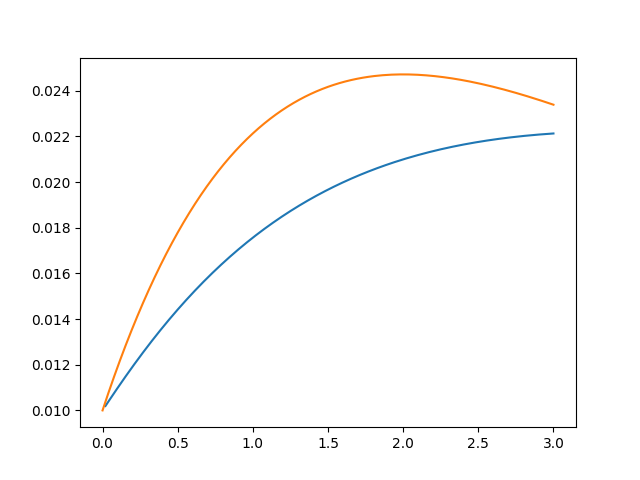

In [ ]:
from functools import partial
def get_instant_vol_func(tau_i , a,b,c,d):

    tau = np.maximum(tau_i, 0)
    instantaneous_vol = (a + b * tau) * np.exp(-c * tau) + d
    return instantaneous_vol

def doust_corr(tau_i,tau_j, eta, beta):
    return eta + (1-eta) * np.exp(-beta*np.abs(tau_i-tau_j))

def trainable_kernel(tau_i, tau_j, a, b, c, d, eta, beta):
    return doust_corr(eta, beta, tau_i,tau_j) * get_instant_vol_func(tau_j , a,b,c,d) / get_instant_vol_func(tau_i , a,b,c,d)
    


low_bounds = {'a': 0.00, 'b': 0.02, 'c': 0.5, 'd': 0.01}

ts = np.linspace(0,3,105+52) # 3 yers
#np.trapz()
T = ts[-1]
tau = T - ts
vols = get_instant_vol_func(ts,**low_bounds)
delta_kernel =  vols#[:,None]#/vols[52] # normalized to 1y marklt.plot(ts, )
# 3) instantaneous vols as function of tau
vol_tau = get_instant_vol_func(tau, **low_bounds)

# 4) square them
sq = vol_tau**2

# 5) for each index i, integrate σ^2 over [t_i, T] by integrating sq[i:] against ts[i:]
tail_vars = np.array([
    np.trapz(sq[i:], ts[i:])
    for i in range(len(ts)-1)   # we stop at i=len(ts)-2 to avoid dividing by zero
])

# 6) annualise forward vol on [t_i, T]:
#     forward_vol[i] = sqrt( ∫ₜᵢᵀ σ²(u) du  /  (T−t_i) )
forward_vol = np.sqrt(tail_vars / tau[:-1])

# 7) plot it **against** τ = time‐to‐expiry
plt.clf()
plt.plot(tau[:-1], forward_vol)
plt.plot(ts,delta_kernel)
plt.show()

In [ ]:
ts = np.arange(0,3,1/52) # 3 yers
ts[104]

2.0

In [65]:
import numpy as np
import sonnet as snt
import tensorflow as tf
import tensorflow_probability as tfp

# Alias for bijectors
tfb = tfp.bijectors

class OneYearKernelLayer(snt.Module):
    """
    Sonnet module acting like a layer: takes a risk vector [T] and returns
    a single exposure scalar. Internally computes trainable kernel weights
    anchored at a fixed tenor (1y at index anchor_index).

    Usage:
        exposure = kernel_layer(risk_vector)

    Parameters a,b,c,d,eta,beta are constrained to (0,1) via Sigmoid bijector.
    """
    def __init__(self,
                 tenor_grid=None,
                 anchor_index=52,
                 init_params=None,
                 a_scale = 0.2,
                 b_scale=0.2,
                 c_scale = 1.5,
                 d_scale=0.5,

                 name=None):
        super().__init__(name=name)
        # Build tenor grid: default 0 to 3 years at 1/52
        if tenor_grid is None:
            tau_vals = np.arange(0, 2+1e-5, 1/52).astype(np.float32)
        else:
            tau_vals = np.array(tenor_grid, dtype=np.float32)
        self.tau_grid = tf.constant(tau_vals, dtype=tf.float32)
        self.anchor_index = anchor_index

        # Initial params in (0,1)
        defaults = init_params or {'a':0.5,'b':0.5,'c':1.,'d':0.001,'eta':0.5,'beta':0.5}
        sigmoid = tfb.Sigmoid()
        # Vol function params
        self.a    = tfp.util.TransformedVariable(defaults['a'],    sigmoid, name='a') * a_scale
        self.b    = tfp.util.TransformedVariable(defaults['b'],    sigmoid, name='b') * b_scale
        self.c    = tfp.util.TransformedVariable(defaults['c'],    sigmoid, name='c') * c_scale
        self.d    = tfp.util.TransformedVariable(defaults['d'],    sigmoid, name='d')*d_scale + 0.001
        # Correlation params
        self.eta  = tfp.util.TransformedVariable(defaults['eta'],  sigmoid, name='eta')*0.95
        self.beta = tfp.util.TransformedVariable(defaults['beta'], sigmoid, name='beta')*0.5

    def _compute_weights(self):
        """
        Compute the kernel weight vector [T]."""
        tau = self.tau_grid                             # [T]
        vols = (self.a + self.b * tau)*tf.exp(-self.c * tau) + self.d  # [T]
        vol_ref = vols[self.anchor_index]                # scalar
        tau_ref = tau[self.anchor_index]                 # scalar
        dist = tf.abs(tau - tau_ref)                     # [T]
        corr = self.eta + (1. - self.eta)*tf.exp(-self.beta * dist)  # [T]
        return corr * (vols / vol_ref)                   # [T]

    def __call__(self, risk_vector):
        """
        Args:
          risk_vector: 1D tensor [T] of risk sensitivities.
        Returns:
          scalar exposure.
        """
        weights = self._compute_weights()                # [T]
        plt.clf()
        plt.plot(weights)
        plt.show()
        return tf.reduce_sum(weights * risk_vector)      # scalar

In [ ]:
layer = OneYearKernelLayer()

In [ ]:
a1 = np.arange(10)[None,:]
a2 = np.arange(10)[None,:]
np.concatenate([a1,a2],axis=0)

array([[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
       [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]])

In [ ]:
t=52
gv = np.arange(1,3+1e-3,1/52)[:53+t]
gt = np.zeros(105)
gt[52-t:] = gv

print(gt[:,None][52])

[2.]
